In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

In [2]:
p = symbols('p:3', real=True)
v = symbols('v:3', real=True)
a = symbols('a:3', real=True)
t = symbols('t', real=True)
o = symbols('o:6', real=True)

In [3]:
model = Matrix([
    p[0] + v[0]*t + (a[0]*t**2)/2,
    p[1] + v[1]*t + (a[1]*t**2)/2,
    p[2] + v[2]*t + (a[2]*t**2)/2,
    tanh(v[0] + a[0]*t),
    tanh(v[1] + a[1]*t),
    tanh(v[2] + a[2]*t),
])
model

⎡    2            ⎤
⎢a₀⋅t             ⎥
⎢───── + p₀ + t⋅v₀⎥
⎢  2              ⎥
⎢                 ⎥
⎢    2            ⎥
⎢a₁⋅t             ⎥
⎢───── + p₁ + t⋅v₁⎥
⎢  2              ⎥
⎢                 ⎥
⎢    2            ⎥
⎢a₂⋅t             ⎥
⎢───── + p₂ + t⋅v₂⎥
⎢  2              ⎥
⎢                 ⎥
⎢ tanh(a₀⋅t + v₀) ⎥
⎢                 ⎥
⎢ tanh(a₁⋅t + v₁) ⎥
⎢                 ⎥
⎣ tanh(a₂⋅t + v₂) ⎦

In [4]:
J_model = model.jacobian((*p,*v))
J_model

⎡1  0  0            t                       0                       0         
⎢                                                                             
⎢0  1  0            0                       t                       0         
⎢                                                                             
⎢0  0  1            0                       0                       t         
⎢                                                                             
⎢               2                                                             
⎢0  0  0  - tanh (a₀⋅t + v₀) + 1            0                       0         
⎢                                                                             
⎢                                       2                                     
⎢0  0  0            0             - tanh (a₁⋅t + v₁) + 1            0         
⎢                                                                             
⎢                                                   

In [5]:
observe = Matrix(o[:3])
observe

⎡o₀⎤
⎢  ⎥
⎢o₁⎥
⎢  ⎥
⎣o₂⎦

In [6]:
J_observe = observe.jacobian(o)
J_observe

⎡1  0  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎣0  0  1  0  0  0⎦

In [7]:
lambda_model = lambdify((*p,*v,*a,t), model)
lambda_J_model = lambdify((*p,*v,*a,t), J_model)
lambda_observe = lambdify(o, observe)
lambda_J_observe = lambdify(o, J_observe)

In [8]:
def ekf(state, covar, control, measure, q=1e-3, r=1e-3):
    predict_state = lambda_model(*state[:,0], *control[:,0])
    F = lambda_J_model(*state[:,0], *control[:,0])
    Q = np.random.randn(*[F.shape[0]]*2) * q
    predict_covar = F @ covar @ F.T + Q
    residual_state = measure - lambda_observe(*predict_state[:,0])
    H = lambda_J_observe(*predict_state[:,0])
    R = np.random.randn(*[H.shape[0]]*2) * r
    PHt = predict_covar @ H.T
    residual_covar = H @ PHt + R
    try:
        kalman_gain = PHt @ np.linalg.inv(residual_covar)
    except:
        return state, covar
    updated_state = predict_state + kalman_gain @ residual_state
    updated_covar = (np.identity(F.shape[0]) - (kalman_gain @ H)) @ predict_covar
    return updated_state, updated_covar

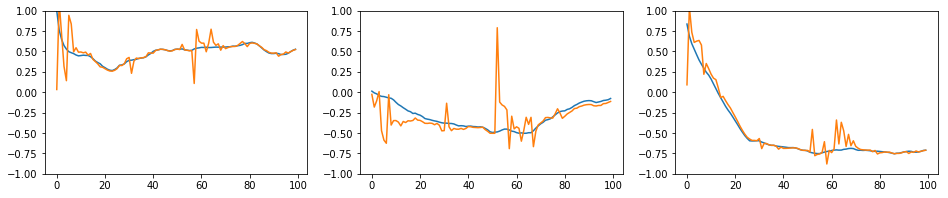

In [9]:
state_real = np.random.randn(6)[:,np.newaxis] * 10
state_real[0,0] = abs(state_real[0,0])
state_esti = np.array([0,0,0,0,0,0])[:,np.newaxis]
covar_esti = np.identity(state_esti.shape[0]) * 1e3
control = np.array([0,0,0,1e-2])[:,np.newaxis]
states = []
for i in range(100):
    control[:3,0] += np.random.randn(3)
    state_real = lambda_model(*state_real[:,0], *control[:,0])
    measure = lambda_observe(*state_real[:,0])
    measure += np.random.randn(*measure.shape) * 1e-3
    state_esti, covar_esti = ekf(state_esti, covar_esti, control, measure)
    states.append(np.concatenate([state_real, state_esti], axis=-1))
states = np.array(states)
plt.figure(figsize=(16,3))
plt.subplot(131)
plt.ylim(-1,1)
plt.plot(states[:,3])
plt.subplot(132)
plt.ylim(-1,1)
plt.plot(states[:,4])
plt.subplot(133)
plt.ylim(-1,1)
plt.plot(states[:,5])
plt.show()